In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import optuna

# MAMGD Optimizer Class

Gradient optimization method using exponential damping and second-order discrete derivative for neural networks and multidimensional real functions

In [28]:
class MAMGD(keras.optimizers.Optimizer):
    def __init__(
        self,
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        k=0.00001,
        epsilon=1e-7,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        jit_compile=True,
        name="MAMGD",
        **kwargs
    ):
        super().__init__(
            name=name,
            weight_decay=weight_decay,
            clipnorm=clipnorm,
            clipvalue=clipvalue,
            global_clipnorm=global_clipnorm,
            use_ema=use_ema,
            ema_momentum=ema_momentum,
            ema_overwrite_frequency=ema_overwrite_frequency,
            jit_compile=jit_compile,
            **kwargs
        )
        self._learning_rate = self._build_learning_rate(learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.k = k
        self.epsilon = epsilon

    def build(self, var_list):
        super().build(var_list)
        if hasattr(self, "_built") and self._built:
            return
        self._momentums = []
        self._accumulators = []
        self._var = []
        self._grad = []
        for var in var_list:
            self._momentums.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="v"
                )
            )
            self._accumulators.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="R"
                )
            )
            self._var.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="var"
                )
            )
            self._grad.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="G"
                )
            )
        self._built = True

    def update_step(self, gradient, variable):

      lr = tf.cast(self.learning_rate, variable.dtype)
      local_step = tf.cast(self.iterations + 1, variable.dtype)
      beta_1 = tf.cast(self.beta_1 * tf.exp(-self.k * (local_step - 1)), variable.dtype)
      beta_2 = tf.cast(self.beta_2 * tf.exp(-self.k * (local_step - 1)), variable.dtype)
      beta_1_power = tf.pow(beta_1, local_step)
      beta_2_power = tf.pow(beta_2, local_step)

      var_key = self._var_key(variable)
      v = self._momentums[self._index_dict[var_key]]
      R = self._accumulators[self._index_dict[var_key]]
      var = self._var[self._index_dict[var_key]]
      G = self._grad[self._index_dict[var_key]]

      alpha = lr * (1 - beta_2_power) / (1 - beta_1_power)

      v.assign(beta_1 * v + (1 - beta_1) * gradient)
      R.assign(beta_2 * R + (1 - beta_2) * gradient ** 2)
      var0 = var
      G0 = G
      var.assign(variable)
      G.assign(gradient)
      variable.assign_sub((v * alpha) / (tf.sqrt(tf.square((gradient - G0) / ((variable - var0) + self.epsilon)) + R) + self.epsilon))

    def get_config(self):
        config = super().get_config()

        config.update(
            {
                "learning_rate": self._serialize_hyperparameter(
                    self._learning_rate
                ),
                "beta_1": self.beta_1,
                "beta_2": self.beta_2,
                "k": self.k,
                "epsilon": self.epsilon,
            }
        )
        return config


# Minimization tests

The MSE (Mean squared error) metric was used as the error estimate.

## Tests for minimizing a quadratic function

Finding the exponential decay coefficient

In [ ]:
def objective(trial):
    k = trial.suggest_float('k', 0, 10)
    MAMGD0 = []

    for N in range(1, 19):

      x = tf.Variable(-1.0)
      y = lambda: x ** 2 - x

      opt = MAMGD(learning_rate=0.1, k=k)
      for n in range(N):
        opt.minimize(y, [x])
      MAMGD0.append((0.5 - x) ** 2)

    return MAMGD0[-1]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-07-28 14:09:27,207] A new study created in memory with name: no-name-ee00ff45-5377-4ba0-a44e-f90e5faf91c5
[I 2024-07-28 14:09:31,368] Trial 0 finished with value: 1.8226220390715753e-06 and parameters: {'k': 2.881937225014113}. Best is trial 0 with value: 1.8226220390715753e-06.
[I 2024-07-28 14:09:33,893] Trial 1 finished with value: 2.896637397498125e-06 and parameters: {'k': 3.0899473492330234}. Best is trial 0 with value: 1.8226220390715753e-06.
[I 2024-07-28 14:09:34,967] Trial 2 finished with value: 3.0796036298852414e-06 and parameters: {'k': 3.12559825220579}. Best is trial 0 with value: 1.8226220390715753e-06.
[I 2024-07-28 14:09:36,049] Trial 3 finished with value: 9.412441613676492e-06 and parameters: {'k': 5.783863723694745}. Best is trial 0 with value: 1.8226220390715753e-06.
[I 2024-07-28 14:09:37,121] Trial 4 finished with value: 2.5876265681290533e-06 and parameters: {'k': 3.0301602598910247}. Best is trial 0 with value: 1.8226220390715753e-06.
[I 2024-07-28 14:

{'k': 2.3810217518681194}

Tests for minimizing a quadratic function

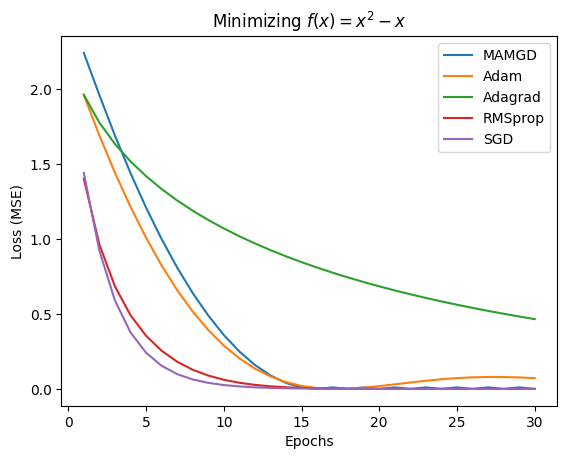

In [ ]:
def test_minimization():

  df_test = {"Epoch": [],
             "MAMGD Loss": [],
             "Adam Loss": [],
             "Adagrad Loss": [],
             "RMSprop Loss": [],
             "SGD Loss": []}

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 31):

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = MAMGD(learning_rate=0.1, k=2.3810217518681194)
    for n in range(N):
      opt.minimize(y, [x])
    MAMGD0.append((0.5 - x) ** 2)

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    Adam.append((0.5 - x) ** 2)

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    Adagrad.append((0.5 - x) ** 2)

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    RMSprop.append((0.5 - x) ** 2)

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    SGD.append((0.5 - x) ** 2)

    if N % 2 == 0 and N != 0:
      df_test["Epoch"].append(N)
      df_test["MAMGD Loss"].append(float(MAMGD0[-1]))
      df_test["Adam Loss"].append(float(Adam[-1]))
      df_test["Adagrad Loss"].append(float(Adagrad[-1]))
      df_test["RMSprop Loss"].append(float(RMSprop[-1]))
      df_test["SGD Loss"].append(float(SGD[-1]))

  plt.plot(np.arange(1, 31), MAMGD0, label="MAMGD")
  plt.plot(np.arange(1, 31), Adam, label="Adam")
  plt.plot(np.arange(1, 31), Adagrad, label="Adagrad")
  plt.plot(np.arange(1, 31), RMSprop, label="RMSprop")
  plt.plot(np.arange(1, 31), SGD, label="SGD")

  plt.title(r"Minimizing $f(x) = x^2-x$")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

  df_test = pd.DataFrame(df_test)
  return df_test

df_test_1 = test_minimization()

Table of values ​​of the objective function of the error from the epoch

In [ ]:
df_test_1

,Epoch,MAMGD Loss,Adam Loss,Adagrad Loss,RMSprop Loss,SGD Loss
0,2,1.959703e+00,1.690626,1.775573,9.634172e-01,0.921600
1,4,1.439806e+00,1.214850,1.517669,4.920814e-01,0.377487
2,6,9.998386e-01,0.823812,1.333152,2.547886e-01,0.154619
3,8,6.398710e-01,0.516539,1.188714,1.280986e-01,0.063332
4,10,3.599032e-01,0.289402,1.070271,6.102682e-02,0.025941
5,12,1.599355e-01,0.135676,0.970315,2.702687e-02,0.010625
6,14,3.996776e-02,0.045391,0.884294,1.093240e-02,0.004352
7,16,6.494020e-09,0.005672,0.809204,3.968211e-03,0.001783
8,18,2.032743e-08,0.001759,0.742943,1.268454e-03,0.000730
9,20,3.152835e-08,0.018631,0.683974,3.496979e-04,0.000299


Table of values to LaTeX table

In [ ]:
print(df_test_1.to_latex(index=False,
                         caption="Quadratic function",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{Quadratic function}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & Adagrad Loss & RMSprop Loss & SGD Loss \\
\midrule
2 & 1.959703 & 1.690626 & 1.775573 & 0.963417 & 0.921600 \\
4 & 1.439806 & 1.214850 & 1.517669 & 0.492081 & 0.377487 \\
6 & 0.999839 & 0.823812 & 1.333152 & 0.254789 & 0.154619 \\
8 & 0.639871 & 0.516539 & 1.188714 & 0.128099 & 0.063332 \\
10 & 0.359903 & 0.289402 & 1.070271 & 0.061027 & 0.025941 \\
12 & 0.159935 & 0.135676 & 0.970315 & 0.027027 & 0.010625 \\
14 & 0.039968 & 0.045391 & 0.884294 & 0.010932 & 0.004352 \\
16 & 0.000000 & 0.005672 & 0.809204 & 0.003968 & 0.001783 \\
18 & 0.000000 & 0.001759 & 0.742943 & 0.001268 & 0.000730 \\
20 & 0.000000 & 0.018631 & 0.683974 & 0.000350 & 0.000299 \\
22 & 0.000000 & 0.042904 & 0.631133 & 0.000081 & 0.000123 \\
24 & 0.000000 & 0.064453 & 0.583516 & 0.000015 & 0.000050 \\
26 & 0.000000 & 0.077261 & 0.540403 & 0.000002 & 0.000021 \\
28 & 0.000000 & 0.079330 & 0.501213 & 

## Spherical function minimization tests

Finding the exponential decay coefficient

In [ ]:
def objective(trial):
    k = trial.suggest_float('k', 0, 10)
    MAMGD0 = []

    for N in range(1, 19):

      x = tf.Variable(-1.5)
      y = tf.Variable(-1.5)
      z = lambda: x ** 2 + y ** 2

      opt = MAMGD(learning_rate=0.1, k=k)
      for n in range(N):
        opt.minimize(z, [x, y])
      MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    return MAMGD0[-1]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-07-28 14:15:27,189] A new study created in memory with name: no-name-c79e4c4c-77cf-4d49-8569-b3013f15d9fb
[I 2024-07-28 14:15:28,983] Trial 0 finished with value: 0.00021884567104279995 and parameters: {'k': 0.901332829931597}. Best is trial 0 with value: 0.00021884567104279995.
[I 2024-07-28 14:15:31,000] Trial 1 finished with value: 9.789789146452677e-06 and parameters: {'k': 6.7897154264535775}. Best is trial 1 with value: 9.789789146452677e-06.
[I 2024-07-28 14:15:32,815] Trial 2 finished with value: 6.134188879514113e-06 and parameters: {'k': 3.82731479189062}. Best is trial 2 with value: 6.134188879514113e-06.
[I 2024-07-28 14:15:35,356] Trial 3 finished with value: 8.138581506500486e-06 and parameters: {'k': 4.61135143416115}. Best is trial 2 with value: 6.134188879514113e-06.
[I 2024-07-28 14:15:37,404] Trial 4 finished with value: 0.0019327565096318722 and parameters: {'k': 0.3689376650884024}. Best is trial 2 with value: 6.134188879514113e-06.
[I 2024-07-28 14:15:39,1

{'k': 2.377131029618243}

Spherical function minimization tests

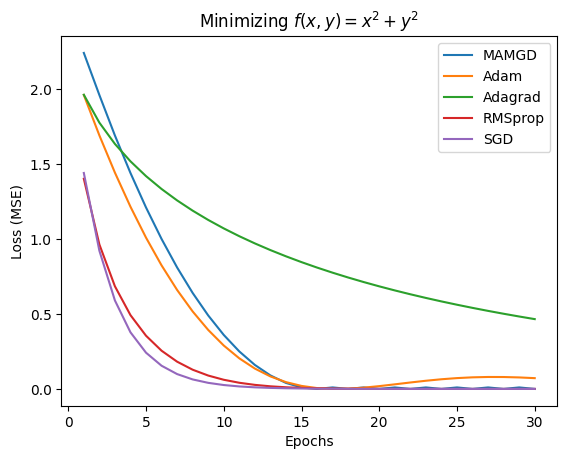

In [ ]:
def test_multiminimization():

  df_test = {"Epoch": [],
             "MAMGD Loss": [],
             "Adam Loss": [],
             "Adagrad Loss": [],
             "RMSprop Loss": [],
             "SGD Loss": []}

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 31):

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = MAMGD(learning_rate=0.1, k=2.377131029618243)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    if N % 2 == 0 and N != 0:
      df_test["Epoch"].append(N)
      df_test["MAMGD Loss"].append(float(MAMGD0[-1]))
      df_test["Adam Loss"].append(float(Adam[-1]))
      df_test["Adagrad Loss"].append(float(Adagrad[-1]))
      df_test["RMSprop Loss"].append(float(RMSprop[-1]))
      df_test["SGD Loss"].append(float(SGD[-1]))

  plt.plot(np.arange(1, 31), MAMGD0, label="MAMGD")
  plt.plot(np.arange(1, 31), Adam, label="Adam")
  plt.plot(np.arange(1, 31), Adagrad, label="Adagrad")
  plt.plot(np.arange(1, 31), RMSprop, label="RMSprop")
  plt.plot(np.arange(1, 31), SGD, label="SGD")

  plt.title(r"Minimizing $f(x,y) = x^2+y^2$")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

  df_test = pd.DataFrame(df_test)
  return df_test

df_test_2 = test_multiminimization()

Table of values ​​of the objective function of the error from the epoch

In [ ]:
df_test_2

,Epoch,MAMGD Loss,Adam Loss,Adagrad Loss,RMSprop Loss,SGD Loss
0,2,1.959738e+00,1.690627,1.775573,9.634173e-01,0.921600
1,4,1.439837e+00,1.214850,1.517669,4.920814e-01,0.377487
2,6,9.998645e-01,0.823812,1.333151,2.547886e-01,0.154619
3,8,6.398916e-01,0.516539,1.188714,1.280986e-01,0.063332
4,10,3.599187e-01,0.289402,1.070271,6.102680e-02,0.025941
5,12,1.599458e-01,0.135676,0.970315,2.702686e-02,0.010625
6,14,3.997292e-02,0.045391,0.884294,1.093239e-02,0.004352
7,16,4.575686e-09,0.005672,0.809204,3.968212e-03,0.001783
8,18,2.001000e-08,0.001759,0.742942,1.268454e-03,0.000730
9,20,3.123797e-08,0.018631,0.683973,3.496975e-04,0.000299


Table of values to LaTeX table

In [ ]:
print(df_test_2.to_latex(index=False,
                         caption="Spherical function",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{Spherical function}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & Adagrad Loss & RMSprop Loss & SGD Loss \\
\midrule
2 & 1.959738 & 1.690627 & 1.775573 & 0.963417 & 0.921600 \\
4 & 1.439837 & 1.214850 & 1.517669 & 0.492081 & 0.377487 \\
6 & 0.999864 & 0.823812 & 1.333151 & 0.254789 & 0.154619 \\
8 & 0.639892 & 0.516539 & 1.188714 & 0.128099 & 0.063332 \\
10 & 0.359919 & 0.289402 & 1.070271 & 0.061027 & 0.025941 \\
12 & 0.159946 & 0.135676 & 0.970315 & 0.027027 & 0.010625 \\
14 & 0.039973 & 0.045391 & 0.884294 & 0.010932 & 0.004352 \\
16 & 0.000000 & 0.005672 & 0.809204 & 0.003968 & 0.001783 \\
18 & 0.000000 & 0.001759 & 0.742942 & 0.001268 & 0.000730 \\
20 & 0.000000 & 0.018631 & 0.683973 & 0.000350 & 0.000299 \\
22 & 0.000000 & 0.042904 & 0.631133 & 0.000081 & 0.000123 \\
24 & 0.000000 & 0.064453 & 0.583516 & 0.000015 & 0.000050 \\
26 & 0.000000 & 0.077261 & 0.540403 & 0.000002 & 0.000021 \\
28 & 0.000000 & 0.079330 & 0.501213 & 

## Three-hump camel function minimization test

Finding the exponential decay coefficient

In [ ]:
def objective(trial):
    k = trial.suggest_float('k', 0, 10)
    MAMGD0 = []

    for N in range(1, 19):

      x = tf.Variable(1.0)
      y = tf.Variable(1.0)
      z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

      opt = MAMGD(learning_rate=0.1, k=k)
      for n in range(N):
        opt.minimize(z, [x, y])
      MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    return MAMGD0[-1]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-07-28 14:22:19,930] A new study created in memory with name: no-name-b13938f7-4fbf-419d-a168-55b3f33890f1
[I 2024-07-28 14:22:22,696] Trial 0 finished with value: 0.0073845055885612965 and parameters: {'k': 0.9358949818115081}. Best is trial 0 with value: 0.0073845055885612965.
[I 2024-07-28 14:22:25,725] Trial 1 finished with value: 0.009429931640625 and parameters: {'k': 4.739474381079212}. Best is trial 0 with value: 0.0073845055885612965.
[I 2024-07-28 14:22:27,891] Trial 2 finished with value: 0.008168619126081467 and parameters: {'k': 1.1521246424145815}. Best is trial 0 with value: 0.0073845055885612965.
[I 2024-07-28 14:22:30,220] Trial 3 finished with value: 0.009638333693146706 and parameters: {'k': 3.1732158041884952}. Best is trial 0 with value: 0.0073845055885612965.
[I 2024-07-28 14:22:32,452] Trial 4 finished with value: 0.00860096886754036 and parameters: {'k': 1.3116763588355973}. Best is trial 0 with value: 0.0073845055885612965.
[I 2024-07-28 14:22:34,671] Tr

{'k': 0.05340795593118066}

Three-hump camel function minimization test

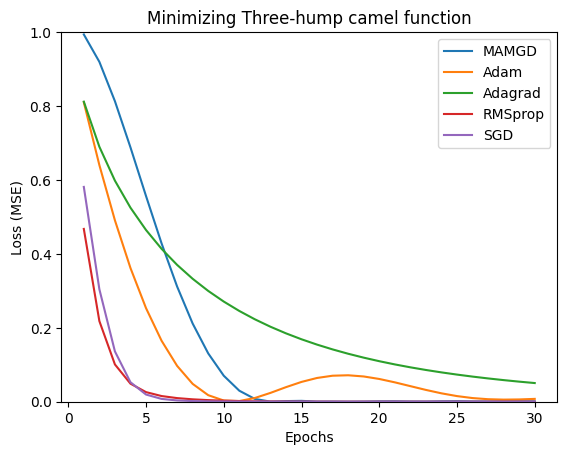

In [ ]:
def test_three_hump_camel_function():

  df_test = {"Epoch": [],
             "MAMGD Loss": [],
             "Adam Loss": [],
             "Adagrad Loss": [],
             "RMSprop Loss": [],
             "SGD Loss": []}

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 31):

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = MAMGD(learning_rate=0.1, k=0.05340795593118066)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    if N % 2 == 0 and N != 0:
      df_test["Epoch"].append(N)
      df_test["MAMGD Loss"].append(float(MAMGD0[-1]))
      df_test["Adam Loss"].append(float(Adam[-1]))
      df_test["Adagrad Loss"].append(float(Adagrad[-1]))
      df_test["RMSprop Loss"].append(float(RMSprop[-1]))
      df_test["SGD Loss"].append(float(SGD[-1]))

  plt.plot(np.arange(1, 31), MAMGD0, label="MAMGD")
  plt.plot(np.arange(1, 31), Adam, label="Adam")
  plt.plot(np.arange(1, 31), Adagrad, label="Adagrad")
  plt.plot(np.arange(1, 31), RMSprop, label="RMSprop")
  plt.plot(np.arange(1, 31), SGD, label="SGD")

  plt.ylim(0, 1)
  plt.title("Minimizing Three-hump camel function")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

  df_test = pd.DataFrame(df_test)
  return df_test

df_test_3 = test_three_hump_camel_function()

Table of values ​​of the objective function of the error from the epoch

In [ ]:
df_test_3

,Epoch,MAMGD Loss,Adam Loss,Adagrad Loss,RMSprop Loss,SGD Loss
0,2,0.919596,0.640227,0.689822,2.181302e-01,3.042785e-01
1,4,0.688145,0.361751,0.524967,4.883938e-02,5.273064e-02
2,6,0.428438,0.165042,0.413728,1.536255e-02,7.619966e-03
3,8,0.211503,0.048304,0.332594,6.500939e-03,1.812583e-03
4,10,0.070354,0.003223,0.270984,2.865402e-03,7.123476e-04
5,12,0.007512,0.010078,0.223012,1.170721e-03,3.379638e-04
6,14,0.001704,0.039383,0.185010,4.283534e-04,1.675465e-04
7,16,0.000314,0.064289,0.154523,1.377734e-04,8.380238e-05
8,18,0.000040,0.071570,0.129823,3.820215e-05,4.198854e-05
9,20,0.001036,0.061574,0.109653,8.922209e-06,2.104509e-05


Table of values to LaTeX table

In [ ]:
print(df_test_3.to_latex(index=False,
                         caption="Three-hump camel function",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{Three-hump camel function}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & Adagrad Loss & RMSprop Loss & SGD Loss \\
\midrule
2 & 0.919596 & 0.640227 & 0.689822 & 0.218130 & 0.304278 \\
4 & 0.688145 & 0.361751 & 0.524967 & 0.048839 & 0.052731 \\
6 & 0.428438 & 0.165042 & 0.413728 & 0.015363 & 0.007620 \\
8 & 0.211503 & 0.048304 & 0.332594 & 0.006501 & 0.001813 \\
10 & 0.070354 & 0.003223 & 0.270984 & 0.002865 & 0.000712 \\
12 & 0.007512 & 0.010078 & 0.223012 & 0.001171 & 0.000338 \\
14 & 0.001704 & 0.039383 & 0.185010 & 0.000428 & 0.000168 \\
16 & 0.000314 & 0.064289 & 0.154523 & 0.000138 & 0.000084 \\
18 & 0.000040 & 0.071570 & 0.129823 & 0.000038 & 0.000042 \\
20 & 0.001036 & 0.061574 & 0.109653 & 0.000009 & 0.000021 \\
22 & 0.000542 & 0.042171 & 0.093073 & 0.000002 & 0.000011 \\
24 & 0.001124 & 0.022718 & 0.079367 & 0.000000 & 0.000005 \\
26 & 0.000768 & 0.009898 & 0.067981 & 0.000000 & 0.000003 \\
28 & 0.001377 & 0.005689 & 0.05

## Matyas function minimization test

Finding the exponential decay coefficient

In [ ]:
def objective(trial):
    k = trial.suggest_float('k', 0, 10)
    MAMGD0 = []

    for N in range(1, 15):

      x = tf.Variable(-1.0)
      y = tf.Variable(-1.0)
      z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

      opt = MAMGD(learning_rate=0.1, k=k)
      for n in range(N):
        opt.minimize(z, [x, y])
      MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    return MAMGD0[-1]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-07-28 14:28:19,736] A new study created in memory with name: no-name-b2eea7d0-da7b-4a68-9357-d46b64fcc22b
[I 2024-07-28 14:28:21,052] Trial 0 finished with value: 0.009405691176652908 and parameters: {'k': 4.6218227239778376}. Best is trial 0 with value: 0.009405691176652908.
[I 2024-07-28 14:28:22,302] Trial 1 finished with value: 0.009360977448523045 and parameters: {'k': 1.7437655123419493}. Best is trial 1 with value: 0.009360977448523045.
[I 2024-07-28 14:28:23,508] Trial 2 finished with value: 0.009732826612889767 and parameters: {'k': 2.6441747441079286}. Best is trial 1 with value: 0.009360977448523045.
[I 2024-07-28 14:28:25,232] Trial 3 finished with value: 0.009355935268104076 and parameters: {'k': 6.752754861159388}. Best is trial 3 with value: 0.009355935268104076.
[I 2024-07-28 14:28:27,146] Trial 4 finished with value: 0.009350977838039398 and parameters: {'k': 8.099878521192913}. Best is trial 4 with value: 0.009350977838039398.
[I 2024-07-28 14:28:28,339] Trial

{'k': 0.027338692996177527}

Matyas function minimization test

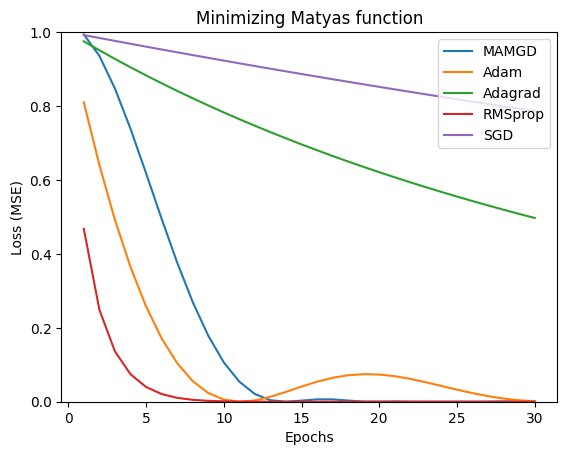

In [47]:
def test_matyas_function():

  df_test = {"Epoch": [],
             "MAMGD Loss": [],
             "Adam Loss": [],
             "Adagrad Loss": [],
             "RMSprop Loss": [],
             "SGD Loss": []}

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 31):

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = MAMGD(learning_rate=0.1, k=0.027338692996177527)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    if N % 2 == 0 and N != 0:
      df_test["Epoch"].append(N)
      df_test["MAMGD Loss"].append(float(MAMGD0[-1]))
      df_test["Adam Loss"].append(float(Adam[-1]))
      df_test["Adagrad Loss"].append(float(Adagrad[-1]))
      df_test["RMSprop Loss"].append(float(RMSprop[-1]))
      df_test["SGD Loss"].append(float(SGD[-1]))

  plt.plot(np.arange(1, 31), MAMGD0, label="MAMGD")
  plt.plot(np.arange(1, 31), Adam, label="Adam")
  plt.plot(np.arange(1, 31), Adagrad, label="Adagrad")
  plt.plot(np.arange(1, 31), RMSprop, label="RMSprop")
  plt.plot(np.arange(1, 31), SGD, label="SGD")

  plt.ylim(0, 1)
  plt.title("Minimizing Matyas function")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend(loc='upper right')
  plt.show()

  df_test = pd.DataFrame(df_test)
  return df_test

df_test_4 = test_matyas_function()

Table of values ​​of the objective function of the error from the epoch

In [48]:
df_test_4

,Epoch,MAMGD Loss,Adam Loss,Adagrad Loss,RMSprop Loss,SGD Loss
0,2,0.935771,0.640684,0.950924,2.489951e-01,0.984096
1,4,0.738803,0.364773,0.904923,7.450246e-02,0.968444
2,6,0.495462,0.171620,0.861725,2.085214e-02,0.953042
3,8,0.270043,0.055840,0.821094,5.086071e-03,0.937885
4,10,0.106671,0.005821,0.782821,1.034805e-03,0.922968
5,12,0.020831,0.003469,0.746721,1.689634e-04,0.908289
6,14,0.000015,0.026615,0.712628,2.122513e-05,0.893844
7,16,0.006423,0.054194,0.680395,1.948341e-06,0.879628
8,18,0.003157,0.071680,0.649889,1.222842e-07,0.865638
9,20,0.000229,0.073522,0.620989,4.798812e-09,0.851871


Table of values ​to LaTeX table

In [49]:
print(df_test_4.to_latex(index=False,
                         caption="Matyas function",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{Matyas function}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & Adagrad Loss & RMSprop Loss & SGD Loss \\
\midrule
2 & 0.935771 & 0.640684 & 0.950924 & 0.248995 & 0.984096 \\
4 & 0.738803 & 0.364773 & 0.904923 & 0.074502 & 0.968444 \\
6 & 0.495462 & 0.171620 & 0.861725 & 0.020852 & 0.953042 \\
8 & 0.270043 & 0.055840 & 0.821094 & 0.005086 & 0.937885 \\
10 & 0.106671 & 0.005821 & 0.782821 & 0.001035 & 0.922968 \\
12 & 0.020831 & 0.003469 & 0.746721 & 0.000169 & 0.908289 \\
14 & 0.000015 & 0.026615 & 0.712628 & 0.000021 & 0.893844 \\
16 & 0.006423 & 0.054194 & 0.680395 & 0.000002 & 0.879628 \\
18 & 0.003157 & 0.071680 & 0.649889 & 0.000000 & 0.865638 \\
20 & 0.000229 & 0.073522 & 0.620989 & 0.000000 & 0.851871 \\
22 & 0.000168 & 0.061779 & 0.593588 & 0.000000 & 0.838322 \\
24 & 0.000080 & 0.042687 & 0.567586 & 0.000000 & 0.824989 \\
26 & 0.000106 & 0.023210 & 0.542893 & 0.000000 & 0.811868 \\
28 & 0.000832 & 0.008589 & 0.519427 & 0.0

## Booth function minimization test

Finding the exponential decay coefficient

In [ ]:
def objective(trial):
    k = trial.suggest_float('k', 0, 10)
    MAMGD0 = []

    for N in range(1, 23):

      x = tf.Variable(0.0)
      y = tf.Variable(1.0)
      z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

      opt = MAMGD(learning_rate=0.1, k=k)
      for n in range(N):
        opt.minimize(z, [x, y])
      MAMGD0.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

    return MAMGD0[-1]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-07-28 14:41:25,182] A new study created in memory with name: no-name-d4854726-7a56-4f13-9b2d-cfcdb78d5a9f
[I 2024-07-28 14:41:28,341] Trial 0 finished with value: 0.009379993192851543 and parameters: {'k': 7.826068469304014}. Best is trial 0 with value: 0.009379993192851543.
[I 2024-07-28 14:41:31,261] Trial 1 finished with value: 0.009203887544572353 and parameters: {'k': 1.6151493763654878}. Best is trial 1 with value: 0.009203887544572353.
[I 2024-07-28 14:41:35,113] Trial 2 finished with value: 0.009377961978316307 and parameters: {'k': 9.67381497225355}. Best is trial 1 with value: 0.009203887544572353.
[I 2024-07-28 14:41:38,061] Trial 3 finished with value: 0.009665417484939098 and parameters: {'k': 3.0820124248294887}. Best is trial 1 with value: 0.009203887544572353.
[I 2024-07-28 14:41:41,009] Trial 4 finished with value: 0.0102659547701478 and parameters: {'k': 0.8436878413526794}. Best is trial 1 with value: 0.009203887544572353.
[I 2024-07-28 14:41:43,836] Trial 5 

{'k': 0.19919259314696333}

Booth function minimization test

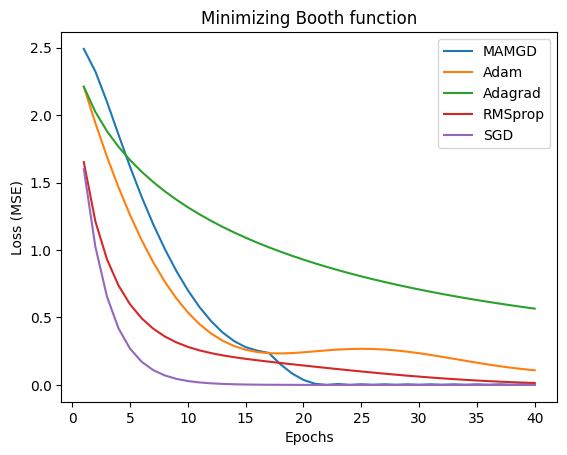

In [ ]:
def test_booth_function():

  df_test = {"Epoch": [],
             "MAMGD Loss": [],
             "Adam Loss": [],
             "Adagrad Loss": [],
             "RMSprop Loss": [],
             "SGD Loss": []}

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 41):

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = MAMGD(learning_rate=0.1, k=0.19919259314696333)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((1 -x ) ** 2 + (3 - y) ** 2) / 2)

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

    if N % 2 == 0 and N != 0:
      df_test["Epoch"].append(N)
      df_test["MAMGD Loss"].append(float(MAMGD0[-1]))
      df_test["Adam Loss"].append(float(Adam[-1]))
      df_test["Adagrad Loss"].append(float(Adagrad[-1]))
      df_test["RMSprop Loss"].append(float(RMSprop[-1]))
      df_test["SGD Loss"].append(float(SGD[-1]))

  plt.plot(np.arange(1, 41),MAMGD0,label="MAMGD")
  plt.plot(np.arange(1, 41),Adam,label="Adam")
  plt.plot(np.arange(1, 41),Adagrad,label="Adagrad")
  plt.plot(np.arange(1, 41),RMSprop,label="RMSprop")
  plt.plot(np.arange(1, 41),SGD,label="SGD")

  plt.title("Minimizing Booth function")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

  df_test = pd.DataFrame(df_test)
  return df_test

df_test_5 = test_booth_function()

Table of values ​​of the objective function of the error from the epoch

In [ ]:
df_test_5

,Epoch,MAMGD Loss,Adam Loss,Adagrad Loss,RMSprop Loss,SGD Loss
0,2,2.323125,1.940616,2.023544,1.212334,1.024000e+00
1,4,1.855067,1.464750,1.765136,0.737108,4.194309e-01
2,6,1.394106,1.073439,1.580268,0.493918,1.717988e-01
3,8,1.008421,0.765555,1.435507,0.359272,7.036885e-02
4,10,0.701519,0.537251,1.316735,0.282088,2.882304e-02
5,12,0.473483,0.381518,1.216434,0.235819,1.180593e-02
6,14,0.324607,0.288052,1.130048,0.205457,4.835678e-03
7,16,0.254285,0.243642,1.054571,0.182560,1.980682e-03
8,18,0.153560,0.233271,0.987901,0.162734,8.112896e-04
9,20,0.037101,0.241822,0.928501,0.144036,3.323058e-04


Table of values to LaTeX table

In [ ]:
print(df_test_5.to_latex(index=False,
                         caption="Booth function",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{Booth function}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & Adagrad Loss & RMSprop Loss & SGD Loss \\
\midrule
2 & 2.323125 & 1.940616 & 2.023544 & 1.212334 & 1.024000 \\
4 & 1.855067 & 1.464750 & 1.765136 & 0.737108 & 0.419431 \\
6 & 1.394106 & 1.073439 & 1.580268 & 0.493918 & 0.171799 \\
8 & 1.008421 & 0.765555 & 1.435507 & 0.359272 & 0.070369 \\
10 & 0.701519 & 0.537251 & 1.316735 & 0.282088 & 0.028823 \\
12 & 0.473483 & 0.381518 & 1.216434 & 0.235819 & 0.011806 \\
14 & 0.324607 & 0.288052 & 1.130048 & 0.205457 & 0.004836 \\
16 & 0.254285 & 0.243642 & 1.054571 & 0.182560 & 0.001981 \\
18 & 0.153560 & 0.233271 & 0.987901 & 0.162734 & 0.000811 \\
20 & 0.037101 & 0.241822 & 0.928501 & 0.144036 & 0.000332 \\
22 & 0.000004 & 0.256036 & 0.875207 & 0.125871 & 0.000136 \\
24 & 0.000409 & 0.266110 & 0.827116 & 0.108274 & 0.000056 \\
26 & 0.000939 & 0.266470 & 0.783509 & 0.091500 & 0.000023 \\
28 & 0.001095 & 0.255578 & 0.743802 & 0.07

## Himmelblaus function minimization test

Finding the exponential decay coefficient

In [ ]:
def objective(trial):
    k = trial.suggest_float('k', 0, 10)
    MAMGD0 = []

    for N in range(1, 15):

      x = tf.Variable(2.0)
      y = tf.Variable(1.0)
      z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

      opt = MAMGD(learning_rate=0.1, k=k)
      for n in range(N):
        opt.minimize(z, [x, y])
      MAMGD0.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    return MAMGD0[-1]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-07-28 14:50:07,908] A new study created in memory with name: no-name-48f7ffc4-9886-4c92-9ef9-551082e0855a
[I 2024-07-28 14:50:09,214] Trial 0 finished with value: 0.009391340427100658 and parameters: {'k': 6.085633399840211}. Best is trial 0 with value: 0.009391340427100658.
[I 2024-07-28 14:50:10,625] Trial 1 finished with value: 0.009385010227560997 and parameters: {'k': 6.703619749495609}. Best is trial 1 with value: 0.009385010227560997.
[I 2024-07-28 14:50:11,943] Trial 2 finished with value: 0.009378013201057911 and parameters: {'k': 9.624779593397676}. Best is trial 2 with value: 0.009378013201057911.
[I 2024-07-28 14:50:13,228] Trial 3 finished with value: 0.009378359653055668 and parameters: {'k': 8.973425182929077}. Best is trial 2 with value: 0.009378013201057911.
[I 2024-07-28 14:50:14,503] Trial 4 finished with value: 0.009392217732965946 and parameters: {'k': 6.023389440222275}. Best is trial 2 with value: 0.009378013201057911.
[I 2024-07-28 14:50:15,753] Trial 5 

{'k': 0.10650640132738051}

Himmelblaus function minimization test

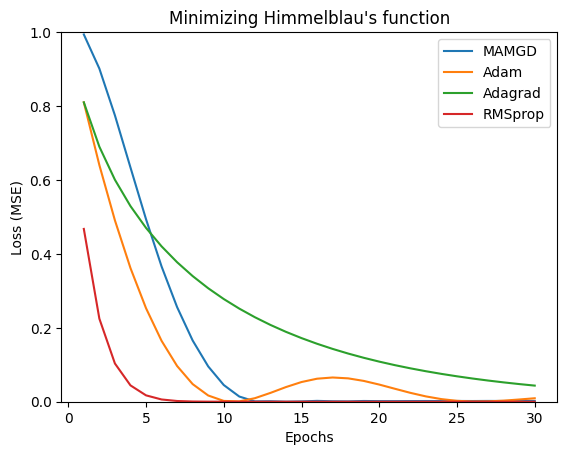

In [44]:
def test_himmelblaus_function():

  df_test = {"Epoch": [],
             "MAMGD Loss": [],
             "Adam Loss": [],
             "Adagrad Loss": [],
             "RMSprop Loss": []}

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 31):

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = MAMGD(learning_rate=0.1, k=0.10650640132738051)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    if N % 2 == 0 and N != 0:
      df_test["Epoch"].append(N)
      df_test["MAMGD Loss"].append(float(MAMGD0[-1]))
      df_test["Adam Loss"].append(float(Adam[-1]))
      df_test["Adagrad Loss"].append(float(Adagrad[-1]))
      df_test["RMSprop Loss"].append(float(RMSprop[-1]))

  plt.plot(np.arange(1, 31),MAMGD0,label="MAMGD")
  plt.plot(np.arange(1, 31),Adam,label="Adam")
  plt.plot(np.arange(1, 31),Adagrad,label="Adagrad")
  plt.plot(np.arange(1, 31),RMSprop,label="RMSprop")
  plt.title("Minimizing Himmelblau's function")

  plt.ylim(0, 1)
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

  df_test = pd.DataFrame(df_test)
  return df_test

df_test_6 = test_himmelblaus_function()

Table of values ​​of the objective function of the error from the epoch

In [45]:
df_test_6

,Epoch,MAMGD Loss,Adam Loss,Adagrad Loss,RMSprop Loss
0,2,0.901249,0.640186,0.689926,2.246426e-01
1,4,0.633748,0.361631,0.529265,4.421171e-02
2,6,0.366014,0.164804,0.420394,6.078302e-03
3,8,0.165643,0.047671,0.339941,5.827936e-04
4,10,0.045176,0.002165,0.277845,6.615451e-05
5,12,0.000891,0.009526,0.228666,1.745980e-05
6,14,0.000068,0.039635,0.189065,5.306682e-06
7,16,0.002296,0.062283,0.156812,1.324354e-06
8,18,0.000905,0.063224,0.130337,2.662114e-07
9,20,0.001584,0.046405,0.108481,4.244160e-08


Table of values to LaTeX

In [46]:
print(df_test_6.to_latex(index=False,
                         caption="Himmelblaus function",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{Himmelblaus function}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & Adagrad Loss & RMSprop Loss \\
\midrule
2 & 0.901249 & 0.640186 & 0.689926 & 0.224643 \\
4 & 0.633748 & 0.361631 & 0.529265 & 0.044212 \\
6 & 0.366014 & 0.164804 & 0.420394 & 0.006078 \\
8 & 0.165643 & 0.047671 & 0.339941 & 0.000583 \\
10 & 0.045176 & 0.002165 & 0.277845 & 0.000066 \\
12 & 0.000891 & 0.009526 & 0.228666 & 0.000017 \\
14 & 0.000068 & 0.039635 & 0.189065 & 0.000005 \\
16 & 0.002296 & 0.062283 & 0.156812 & 0.000001 \\
18 & 0.000905 & 0.063224 & 0.130337 & 0.000000 \\
20 & 0.001584 & 0.046405 & 0.108481 & 0.000000 \\
22 & 0.001781 & 0.024033 & 0.090367 & 0.000000 \\
24 & 0.001766 & 0.007052 & 0.075311 & 0.000000 \\
26 & 0.001884 & 0.000463 & 0.062774 & 0.000000 \\
28 & 0.001978 & 0.002933 & 0.052320 & 0.000000 \\
30 & 0.002048 & 0.009349 & 0.043596 & 0.000000 \\
\bottomrule
\end{tabular}
\end{table}



# Neural Network optimization tests

## Approximation using multilayer neural network

Epoch 1/15
313/313 [==============================] - 4s 6ms/step - loss: 821.6368 - mean_squared_error: 821.6368
Epoch 2/15
313/313 [==============================] - 3s 10ms/step - loss: 111.1590 - mean_squared_error: 111.1590
Epoch 3/15
313/313 [==============================] - 1s 4ms/step - loss: 49.1950 - mean_squared_error: 49.1950
Epoch 4/15
313/313 [==============================] - 1s 3ms/step - loss: 18.5710 - mean_squared_error: 18.5710
Epoch 5/15
313/313 [==============================] - 1s 3ms/step - loss: 5.9156 - mean_squared_error: 5.9156
Epoch 6/15
313/313 [==============================] - 1s 3ms/step - loss: 1.0251 - mean_squared_error: 1.0251
Epoch 7/15
313/313 [==============================] - 1s 2ms/step - loss: 0.2279 - mean_squared_error: 0.2279
Epoch 8/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0940 - mean_squared_error: 0.0940
Epoch 9/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0605 - mean_squared_error: 0.06

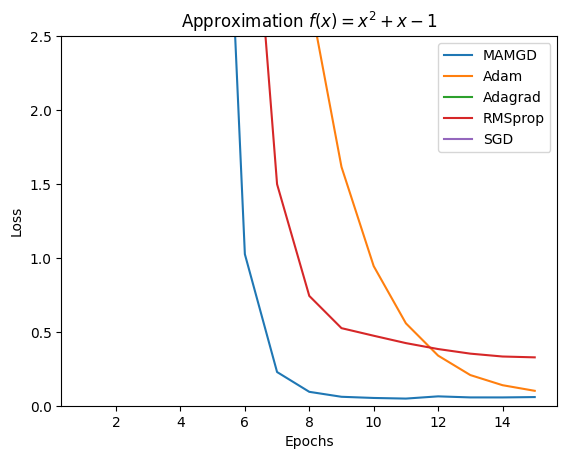

In [ ]:
x = np.linspace(-10, 10, 10000)
y = x ** 2 + x - 1


model_mamgd = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_mamgd.compile(optimizer=MAMGD(learning_rate=0.001, beta_2=0.999, k=0.0001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_mamgd.fit(x, y, epochs=15)
mamgd = history.history["loss"]


model_adam = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_adam.fit(x, y, epochs=15)
adam = history.history["loss"]


model_adagrad = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_adagrad.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_adagrad.fit(x, y, epochs=15)
adagrad = history.history["loss"]


model_rmsprop = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_rmsprop.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_rmsprop.fit(x, y, epochs=15)
rmsprop = history.history["loss"]


model_sgd = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_sgd.fit(x, y, epochs=15)
sgd = history.history["loss"]

plt.plot(np.arange(1, 16), mamgd, label="MAMGD")
plt.plot(np.arange(1, 16), adam, label="Adam")
plt.plot(np.arange(1, 16), adagrad, label="Adagrad")
plt.plot(np.arange(1, 16), rmsprop, label="RMSprop")
plt.plot(np.arange(1, 16), sgd, label="SGD")

plt.ylim(0, 2.5)
plt.title(r"Approximation $f(x) = x^2+x-1$")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

df_test_7 = {"Epoch": 15,
             "MAMGD Loss": mamgd,
             "Adam Loss": adam,
             "Adagrad Loss": adagrad,
             "RMSprop Loss": rmsprop,
             "SGD Loss": sgd}

df_test_7 = pd.DataFrame(df_test_7)

Table of values ​​of the objective function of the error from the epoch

In [ ]:
df_test_7

,Epoch,MAMGD Loss,Adam Loss,Adagrad Loss,RMSprop Loss,SGD Loss
0,15,821.636841,652.494873,1762.779175,655.232788,160.947144
1,15,111.159012,115.097504,1577.810669,112.074127,85.439232
2,15,49.195004,60.046024,1445.563843,55.858692,72.121544
3,15,18.571014,27.468365,1329.008545,24.525091,52.972687
4,15,5.915591,15.148467,1219.975220,11.512796,46.084648
5,15,1.025126,8.855510,1117.438354,4.281589,42.493931
6,15,0.227894,4.974255,1021.298096,1.498476,37.489067
7,15,0.093988,2.775730,931.561707,0.742871,49.106506
8,15,0.060457,1.615357,848.579773,0.524694,32.434353
9,15,0.052484,0.944320,772.376770,0.473356,32.483410


Table of values to LaTeX

In [ ]:
print(df_test_7.to_latex(index=False,
                         caption="Approximation using multilayer neural network",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{Approximation using multilayer neural network}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & Adagrad Loss & RMSprop Loss & SGD Loss \\
\midrule
15 & 821.636841 & 652.494873 & 1762.779175 & 655.232788 & 160.947144 \\
15 & 111.159012 & 115.097504 & 1577.810669 & 112.074127 & 85.439232 \\
15 & 49.195004 & 60.046024 & 1445.563843 & 55.858692 & 72.121544 \\
15 & 18.571014 & 27.468365 & 1329.008545 & 24.525091 & 52.972687 \\
15 & 5.915591 & 15.148467 & 1219.975220 & 11.512796 & 46.084648 \\
15 & 1.025126 & 8.855510 & 1117.438354 & 4.281589 & 42.493931 \\
15 & 0.227894 & 4.974255 & 1021.298096 & 1.498476 & 37.489067 \\
15 & 0.093988 & 2.775730 & 931.561707 & 0.742871 & 49.106506 \\
15 & 0.060457 & 1.615357 & 848.579773 & 0.524694 & 32.434353 \\
15 & 0.052484 & 0.944320 & 772.376770 & 0.473356 & 32.483410 \\
15 & 0.048284 & 0.557275 & 702.738586 & 0.423530 & 28.475237 \\
15 & 0.063352 & 0.338988 & 639.490479 & 0.383350 & 31.728319 \\
15 &

## IMDB Dataset

Epoch 1/20
30/30 [==============================] - 3s 74ms/step - loss: 0.6375 - accuracy: 0.6597 - val_loss: 0.5033 - val_accuracy: 0.8298
Epoch 2/20
30/30 [==============================] - 1s 47ms/step - loss: 0.3737 - accuracy: 0.8825 - val_loss: 0.3208 - val_accuracy: 0.8822
Epoch 3/20
30/30 [==============================] - 2s 67ms/step - loss: 0.2323 - accuracy: 0.9241 - val_loss: 0.2777 - val_accuracy: 0.8898
Epoch 4/20
30/30 [==============================] - 2s 62ms/step - loss: 0.1674 - accuracy: 0.9466 - val_loss: 0.2770 - val_accuracy: 0.8890
Epoch 5/20
30/30 [==============================] - 2s 62ms/step - loss: 0.1272 - accuracy: 0.9588 - val_loss: 0.2912 - val_accuracy: 0.8860
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0983 - accuracy: 0.9719 - val_loss: 0.3150 - val_accuracy: 0.8825
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0752 - accuracy: 0.9795 - val_loss: 0.3446 - val_accuracy: 0.8809
Epoch 8/20
30

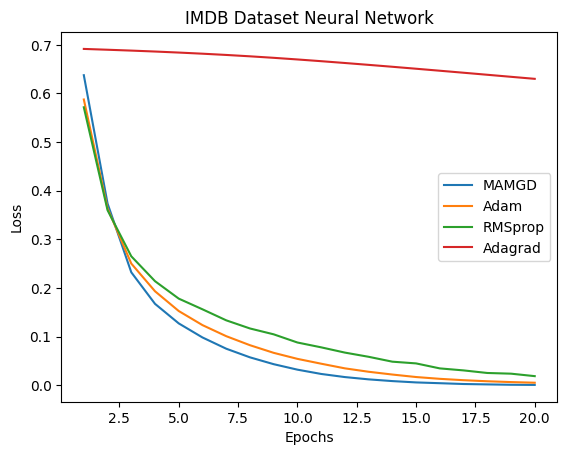

In [30]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def vectorize_sequences(sequences, dimention=10000):
    results = np.zeros((len(sequences), dimention))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype(np.float32)
y_test = np.asarray(test_labels).astype(np.float32)

X_val = X_train[:10000]
y_val = y_train[:10000]

partial_X_train = X_train[10000:]
partial_y_train = y_train[10000:]

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer=MAMGD(learning_rate=0.001, k=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

mamgd = history.history["loss"]

model1 = models.Sequential()
model1.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model1.add(layers.Dense(16, activation="relu"))
model1.add(layers.Dense(1, activation="sigmoid"))

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

adam = history.history["loss"]

model2 = models.Sequential()
model2.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model2.add(layers.Dense(16, activation="relu"))
model2.add(layers.Dense(1, activation="sigmoid"))

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

rmsprop = history.history["loss"]

model3 = models.Sequential()
model3.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model3.add(layers.Dense(16, activation="relu"))
model3.add(layers.Dense(1, activation="sigmoid"))

model3.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

adagrad = history.history["loss"]

plt.plot(np.arange(1, 21), mamgd, label="MAMGD")
plt.plot(np.arange(1, 21), adam, label="Adam")
plt.plot(np.arange(1, 21), rmsprop, label="RMSprop")
plt.plot(np.arange(1, 21), adagrad, label="Adagrad")
plt.title("IMDB Dataset Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

df_test_8 = {"Epoch": [i for i in range(1, 21)],
             "MAMGD Loss": mamgd,
             "Adam Loss": adam,
             "Adagrad Loss": adagrad,
             "RMSprop Loss": rmsprop}

df_test_8 = pd.DataFrame(df_test_8)

Table of values ​​of the objective function of the error from the epoch

In [31]:
df_test_8

,Epoch,MAMGD Loss,Adam Loss,Adagrad Loss,RMSprop Loss
0,20,0.637524,0.587573,0.691539,0.571567
1,20,0.373726,0.363699,0.689856,0.359916
2,20,0.232306,0.250259,0.688095,0.265192
3,20,0.167434,0.193303,0.686177,0.214027
4,20,0.127229,0.152671,0.684051,0.178158
5,20,0.098317,0.123702,0.681721,0.156204
6,20,0.075212,0.100980,0.679159,0.133551
7,20,0.057454,0.082415,0.676337,0.116825
8,20,0.043390,0.066716,0.673241,0.104766
9,20,0.032139,0.054332,0.669879,0.087954


Table of values ​​to LaTeX

In [32]:
print(df_test_8.to_latex(index=False,
                         caption="IMDB Dataset",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{IMDB Dataset}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & Adagrad Loss & RMSprop Loss \\
\midrule
20 & 0.637524 & 0.587573 & 0.691539 & 0.571567 \\
20 & 0.373726 & 0.363699 & 0.689856 & 0.359916 \\
20 & 0.232306 & 0.250259 & 0.688095 & 0.265192 \\
20 & 0.167434 & 0.193303 & 0.686177 & 0.214027 \\
20 & 0.127229 & 0.152671 & 0.684051 & 0.178158 \\
20 & 0.098317 & 0.123702 & 0.681721 & 0.156204 \\
20 & 0.075212 & 0.100980 & 0.679159 & 0.133551 \\
20 & 0.057454 & 0.082415 & 0.676337 & 0.116825 \\
20 & 0.043390 & 0.066716 & 0.673241 & 0.104766 \\
20 & 0.032139 & 0.054332 & 0.669879 & 0.087954 \\
20 & 0.023305 & 0.044377 & 0.666331 & 0.078029 \\
20 & 0.016889 & 0.034820 & 0.662608 & 0.067212 \\
20 & 0.012188 & 0.027816 & 0.658768 & 0.058585 \\
20 & 0.008631 & 0.022097 & 0.654841 & 0.048537 \\
20 & 0.005894 & 0.016978 & 0.650807 & 0.044989 \\
20 & 0.004280 & 0.013270 & 0.646712 & 0.034727 \\
20 & 0.002633 & 0.010459 & 0.642588 & 0.0306

## Boston Housing Price Dataset

Epoch 1/20
404/404 [==============================] - 3s 4ms/step - loss: 350.5948 - mae: 15.5684 - val_loss: 53.7653 - val_mae: 5.3223
Epoch 2/20
404/404 [==============================] - 2s 5ms/step - loss: 33.5318 - mae: 3.9773 - val_loss: 22.2242 - val_mae: 3.1708
Epoch 3/20
404/404 [==============================] - 2s 5ms/step - loss: 20.5121 - mae: 3.0890 - val_loss: 15.3247 - val_mae: 2.6825
Epoch 4/20
404/404 [==============================] - 3s 7ms/step - loss: 16.3965 - mae: 2.7447 - val_loss: 12.5071 - val_mae: 2.4703
Epoch 5/20
404/404 [==============================] - 1s 4ms/step - loss: 12.3593 - mae: 2.4800 - val_loss: 14.5503 - val_mae: 2.8575
Epoch 6/20
404/404 [==============================] - 2s 4ms/step - loss: 12.2931 - mae: 2.4829 - val_loss: 9.9593 - val_mae: 2.1621
Epoch 7/20
404/404 [==============================] - 2s 4ms/step - loss: 12.0990 - mae: 2.4200 - val_loss: 9.3461 - val_mae: 2.1684
Epoch 8/20
404/404 [==============================] - 1s 4ms/s

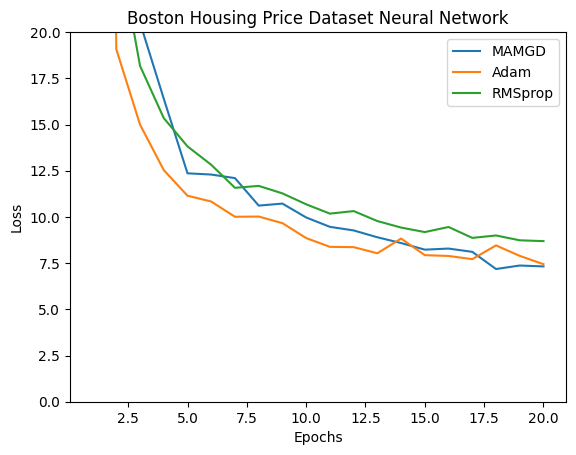

In [ ]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

num_val_samples = train_data.shape[0] // 4
num_epochs = 20
all_scores = []

val_data = train_data
val_targets = train_targets


from keras import models
from keras import layers

model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer=MAMGD(learning_rate=0.001, k=0.000001),
              loss="mse",
              metrics=["mae"])

history = model.fit(train_data, train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1)

mamgd = history.history["loss"]

model1 = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics=["mae"])

history = model1.fit(train_data, train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1)

adam = history.history["loss"]

model2 = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="mse",
              metrics=["mae"])

history = model2.fit(train_data, train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1)

rmsprop = history.history["loss"]

plt.plot(np.arange(1, 21), mamgd, label="MAMGD")
plt.plot(np.arange(1, 21), adam, label="Adam")
plt.plot(np.arange(1, 21), rmsprop, label="RMSprop")

plt.title("Boston Housing Price Dataset Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 20)
plt.legend()
plt.show()

df_test_9 = {"Epoch": [i for i in range(1, 21)],
             "MAMGD Loss": mamgd,
             "Adam Loss": adam,
             "RMSprop Loss": rmsprop}

df_test_9 = pd.DataFrame(df_test_9)

Table of values ​​of the objective function of the error from the epoch

In [ ]:
df_test_9

,Epoch,MAMGD Loss,Adam Loss,RMSprop Loss
0,20,350.594757,140.978012,157.523834
1,20,33.531769,19.073381,25.266592
2,20,20.512051,14.994828,18.173952
3,20,16.396505,12.534935,15.347956
4,20,12.359325,11.147352,13.817107
5,20,12.293142,10.832203,12.820888
6,20,12.098958,10.008436,11.574941
7,20,10.613210,10.020133,11.678750
8,20,10.721079,9.662991,11.273701
9,20,9.970358,8.856193,10.683825


Table of values to LaTeX

In [ ]:
print(df_test_9.to_latex(index=False,
                         caption="Boston Housing Price Dataset",
                         position="htbp",
                         column_format="|l|l|l|l|l|l|",
                         escape=False,
                        )
                    )

\begin{table}[htbp]
\caption{Boston Housing Price Dataset}
\begin{tabular}{|l|l|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & RMSprop Loss \\
\midrule
20 & 350.594757 & 140.978012 & 157.523834 \\
20 & 33.531769 & 19.073381 & 25.266592 \\
20 & 20.512051 & 14.994828 & 18.173952 \\
20 & 16.396505 & 12.534935 & 15.347956 \\
20 & 12.359325 & 11.147352 & 13.817107 \\
20 & 12.293142 & 10.832203 & 12.820888 \\
20 & 12.098958 & 10.008436 & 11.574941 \\
20 & 10.613210 & 10.020133 & 11.678750 \\
20 & 10.721079 & 9.662991 & 11.273701 \\
20 & 9.970358 & 8.856193 & 10.683825 \\
20 & 9.463201 & 8.380616 & 10.177731 \\
20 & 9.269162 & 8.364103 & 10.316528 \\
20 & 8.898938 & 8.032142 & 9.776771 \\
20 & 8.586391 & 8.830625 & 9.423545 \\
20 & 8.228765 & 7.930937 & 9.180243 \\
20 & 8.287912 & 7.887546 & 9.455106 \\
20 & 8.110354 & 7.714012 & 8.865941 \\
20 & 7.180910 & 8.458524 & 8.996699 \\
20 & 7.370471 & 7.891291 & 8.734899 \\
20 & 7.320936 & 7.440734 & 8.690137 \\
\bottomrule
\end{tabular}
\end{

# **MNIST Dataset**

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/10
469/469 [==============================] - 9s 16ms/step - loss: 0.4487 - accuracy: 0.8784
Epoch 2/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1248 - accuracy: 0.9643
Epoch 3/10
469/469 [==============================] - 12s 26ms/step - loss: 0.0777 - accuracy: 0.9768
Epoch 4/10
469/469 [==============================] - 12s 25ms/step - loss: 0.0526 - accuracy: 0.9841
Epoch 5/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0378 - accuracy: 0.9887
Epoch 6/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0264 - accuracy: 0.9921
Epoch 7/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0206 - accuracy: 0.9941
Epoch 8/10
469/469 [==============================] - 12s 25ms/step - loss: 0.0158 - accuracy: 0.9952
Epoch 9/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0116 - accuracy: 0.9966
Epoch 10/10
469/469

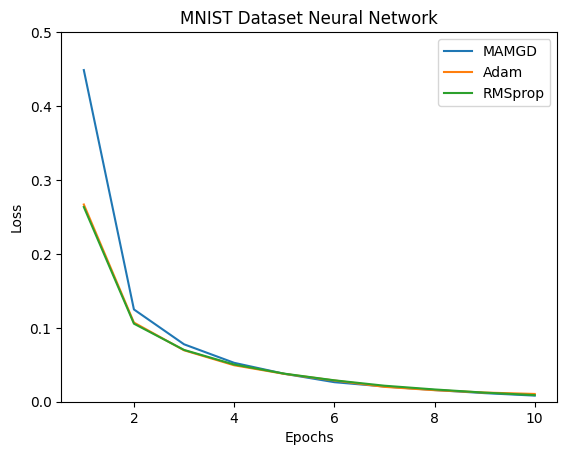

In [33]:
from keras.datasets import mnist


(train_images, train_labels), (test_images, test_labels)  = mnist.load_data()

def flat_images(images):
    return images.reshape((images.shape[0], 28 * 28)).astype("float32") / 255

train_images = flat_images(train_images)
test_images = flat_images(test_images)

from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(512, activation="relu", input_shape=(28 * 28, )))
model.add(layers.Dense(10, activation="softmax"))

model.compile(optimizer=MAMGD(learning_rate=0.001, k=0.00001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

history = model.fit(train_images, train_labels, epochs=10, batch_size=128)

mamgd = history.history["loss"]

model1 = models.Sequential()
model1.add(layers.Dense(512, activation="relu", input_shape=(28 * 28, )))
model1.add(layers.Dense(10, activation="softmax"))

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

history = model1.fit(train_images, train_labels, epochs=10, batch_size=128)

adam = history.history["loss"]

model2 = models.Sequential()
model2.add(layers.Dense(512, activation="relu", input_shape=(28 * 28, )))
model2.add(layers.Dense(10, activation="softmax"))

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

history = model2.fit(train_images, train_labels, epochs=10, batch_size=128)

rmsprop = history.history["loss"]

plt.plot(np.arange(1,11),mamgd,label="MAMGD")
plt.plot(np.arange(1,11),adam,label="Adam")
plt.plot(np.arange(1,11),rmsprop,label="RMSprop")

plt.title("MNIST Dataset Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.5)
plt.legend()
plt.show()

df_test_10 = {"Epoch": [i for i in range (1, 11)],
              "MAMGD Loss": mamgd,
              "Adam Loss": adam,
              "RMSprop Loss": rmsprop}

df_test_10 = pd.DataFrame(df_test_10)

Table of values ​​of the objective function of the error from the epoch

In [34]:
df_test_10

,Epoch,MAMGD Loss,Adam Loss,RMSprop Loss
0,1,0.448672,0.266809,0.263463
1,2,0.124826,0.107094,0.105576
2,3,0.077700,0.069585,0.070089
3,4,0.052628,0.049328,0.050346
4,5,0.037809,0.037673,0.037978
5,6,0.026434,0.028731,0.028972
6,7,0.020605,0.020112,0.021667
7,8,0.015816,0.015615,0.016610
8,9,0.011611,0.012404,0.012298
9,10,0.008266,0.010504,0.008964


Table of values ​to LaTeX

In [36]:
print(df_test_10.to_latex(index=False,
                          caption="MNIST Dataset",
                          position="htbp",
                          column_format="|l|l|l|l|",
                          escape=False,
                         )
                    )

\begin{table}[htbp]
\caption{MNIST Dataset}
\begin{tabular}{|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & RMSprop Loss \\
\midrule
1 & 0.448672 & 0.266809 & 0.263463 \\
2 & 0.124826 & 0.107094 & 0.105576 \\
3 & 0.077700 & 0.069585 & 0.070089 \\
4 & 0.052628 & 0.049328 & 0.050346 \\
5 & 0.037809 & 0.037673 & 0.037978 \\
6 & 0.026434 & 0.028731 & 0.028972 \\
7 & 0.020605 & 0.020112 & 0.021667 \\
8 & 0.015816 & 0.015615 & 0.016610 \\
9 & 0.011611 & 0.012404 & 0.012298 \\
10 & 0.008266 & 0.010504 & 0.008964 \\
\bottomrule
\end{tabular}
\end{table}



## Reuters Dataset

2110848/2110848 [==============================] - 1s 0us/step
Epoch 1/20
16/16 [==============================] - 3s 104ms/step - loss: 3.7850 - accuracy: 0.1227 - val_loss: 3.6826 - val_accuracy: 0.4040
Epoch 2/20
16/16 [==============================] - 2s 124ms/step - loss: 3.4704 - accuracy: 0.4724 - val_loss: 3.1360 - val_accuracy: 0.5110
Epoch 3/20
16/16 [==============================] - 4s 245ms/step - loss: 2.7263 - accuracy: 0.5296 - val_loss: 2.3092 - val_accuracy: 0.5620
Epoch 4/20
16/16 [==============================] - 2s 96ms/step - loss: 1.9002 - accuracy: 0.6274 - val_loss: 1.6317 - val_accuracy: 0.6430
Epoch 5/20
16/16 [==============================] - 1s 55ms/step - loss: 1.3693 - accuracy: 0.7045 - val_loss: 1.3103 - val_accuracy: 0.7080
Epoch 6/20
16/16 [==============================] - 1s 55ms/step - loss: 1.0629 - accuracy: 0.7627 - val_loss: 1.1558 - val_accuracy: 0.7510
Epoch 7/20
16/16 [==============================] - 1s 68ms/step - loss: 0.8456 - accura

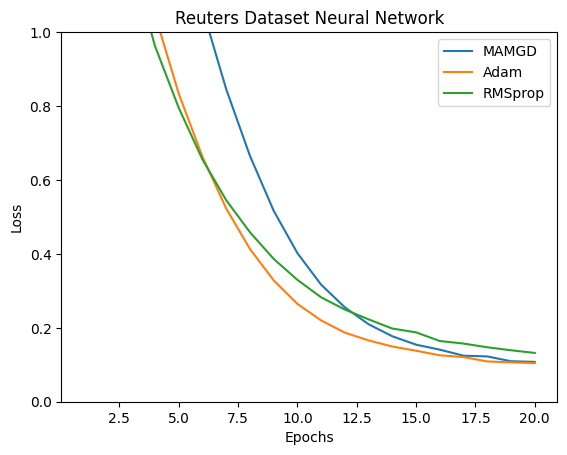

In [37]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

def vectorize_sequences(sequences, dimention=10000):
    results = np.zeros((len(sequences), dimention))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

def to_one_hot(labels, dimention=46):
    results = np.zeros((len(labels), dimention))
    for i, l in enumerate(labels):
        results[i, l] = 1
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

X_val = X_train[:1000]
partial_X_train = X_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

from keras import models
from keras import layers

model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(10000, )),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer=MAMGD(learning_rate=0.001, k=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

mamgd = history.history["loss"]

model1 = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(10000, )),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

adam = history.history["loss"]

model2 = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(10000, )),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

rmsprop = history.history["loss"]

plt.plot(np.arange(1,21),mamgd,label="MAMGD")
plt.plot(np.arange(1,21),adam,label="Adam")
plt.plot(np.arange(1,21),rmsprop,label="RMSprop")

plt.title("Reuters Dataset Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

df_test_11 = {"Epoch": [i for i in range (1, 21)],
              "MAMGD Loss": mamgd,
              "Adam Loss": adam,
              "RMSprop Loss": rmsprop}

df_test_11 = pd.DataFrame(df_test_11)

Table of values ​​of the objective function of the error from the epoch

In [38]:
df_test_11

,Epoch,MAMGD Loss,Adam Loss,RMSprop Loss
0,1,3.785023,3.380734,2.784578
1,2,3.470449,2.057770,1.560803
2,3,2.726303,1.371544,1.194215
3,4,1.900168,1.046967,0.962105
4,5,1.369266,0.833554,0.794977
5,6,1.062885,0.662638,0.655288
6,7,0.845602,0.522731,0.545252
7,8,0.665268,0.413226,0.458509
8,9,0.516712,0.328357,0.386447
9,10,0.402084,0.264667,0.329770


Table of values ​to LaTeX

In [39]:
print(df_test_11.to_latex(index=False,
                          caption="Reuters Dataset",
                          position="htbp",
                          column_format="|l|l|l|l|",
                          escape=False,
                         )
                    )

\begin{table}[htbp]
\caption{Reuters Dataset}
\begin{tabular}{|l|l|l|l|}
\toprule
Epoch & MAMGD Loss & Adam Loss & RMSprop Loss \\
\midrule
1 & 3.785023 & 3.380734 & 2.784578 \\
2 & 3.470449 & 2.057770 & 1.560803 \\
3 & 2.726303 & 1.371544 & 1.194215 \\
4 & 1.900168 & 1.046967 & 0.962105 \\
5 & 1.369266 & 0.833554 & 0.794977 \\
6 & 1.062885 & 0.662638 & 0.655288 \\
7 & 0.845602 & 0.522731 & 0.545252 \\
8 & 0.665268 & 0.413226 & 0.458509 \\
9 & 0.516712 & 0.328357 & 0.386447 \\
10 & 0.402084 & 0.264667 & 0.329770 \\
11 & 0.316678 & 0.219969 & 0.282453 \\
12 & 0.255255 & 0.186874 & 0.249277 \\
13 & 0.209545 & 0.165941 & 0.222823 \\
14 & 0.177048 & 0.149283 & 0.197969 \\
15 & 0.154396 & 0.138011 & 0.187647 \\
16 & 0.140863 & 0.125612 & 0.164271 \\
17 & 0.124534 & 0.120747 & 0.157349 \\
18 & 0.122545 & 0.109029 & 0.147332 \\
19 & 0.109503 & 0.106501 & 0.139231 \\
20 & 0.107755 & 0.104526 & 0.132018 \\
\bottomrule
\end{tabular}
\end{table}

